#### Preference-based Policy Iteration Algorithm

This is an attempt to replicate the work done by Fürnkranz et al., (2012) in their paper "Preference-based reinforcement learning: a formal framework and a policy iteration algorithm"

In [15]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import HTML
import gym
from gym import wrappers
import io
import base64
import itertools
import tqdm

from scipy.stats import rankdata as rd

**State observation**:
    
    Type: Box(4)

    Num     Observation               Min                     Max
    0       Cart Position             -4.8                    4.8
    1       Cart Velocity             -Inf                    Inf
    2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
    3       Pole Angular Velocity     -Inf                    Inf

- For this project, I will describe the state of the pendulum using only the angle and angular velocity of the pole, ignoring the position and the velocity of cart.

**Actions**:

    Type: Discrete(2)
    
    Num   Action
    0     Push cart to the left
    1     Push cart to the right

In [2]:
env = gym.make('CartPole-v0')
env.reset()

print("Number of actions: " + str(env.action_space.n))
print("Observation space: " + str(env.observation_space))
print("Max. values of observation space:" + str(env.observation_space.high))
print("Min. values of observation space:" + str(env.observation_space.low))

Number of actions: 2
Observation space: Box(4,)
Max. values of observation space:[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Min. values of observation space:[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


In [3]:
# helper functions

def state_filter(state):
    """ only use the angle and the angular velocity of the pole to describe the state"""
    
    return state[[2,3]]


def random_action(state):
    """ return a random action: either 0 (left) or 1 (right)"""
    
    action = env.action_space.sample()  
    return action

I generate random samples $S$ in this setting by simulating a uniform random number (max 100) of uniform random actions from the initial state. If the pendulum fell within this sequence, the procedure was repeated.

In [4]:
def generate_init_states_S(seed, filter_state=True):
    """this function returns a list of randomly generated initial states from the CartPole-v0 environment """
    
    np.random.seed(seed)
    
    n_actions = np.random.randint(low=1, high=101)                # how many actions to generate
    seq_actions = np.random.randint(low=0,high=2,size=n_actions)  # random sequence of actions

    init_states_S = []   # to store initial states

    env = gym.make('CartPole-v0')
    env.reset()

    for action in seq_actions:

        state, reward, done, info = env.step(action)  # implement the actions in the random sequence
        
        if filter_state:
            init_states_S.append(state_filter(state)) # append the environment state to list (only angular velocity and angle)
        else:
            init_states_S.append(state) # all 4 state observations
            
        if done: # the episode ends either if the pole is > 15 deg from vertical or the cart move by > 2.4 unit from the centre
            env.reset()    
            
    env.close()
            
    return init_states_S

 Generate a sequence of intial states (for $S$) and display first 10

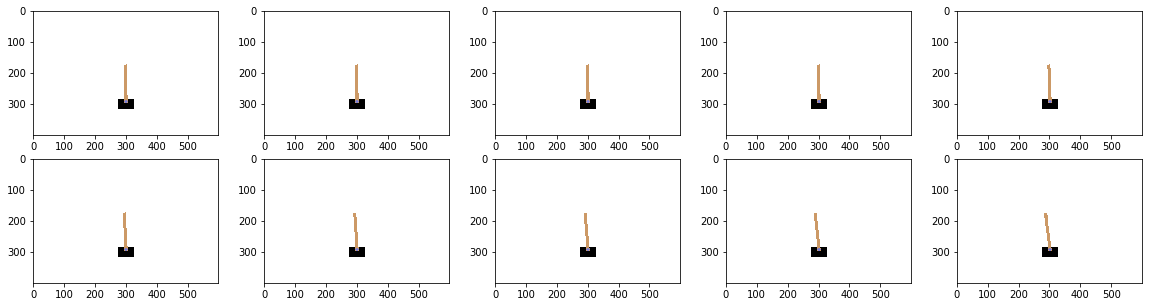

In [5]:
init_states_S = generate_init_states_S(16) # randomly generated states initial

env = gym.make('CartPole-v0') # create inv. pend environment
env = env.unwrapped           # unwrap the environment to send custom initial states
fig = plt.figure(figsize=(20,5))

for i in range(10):
    env.state = np.concatenate((np.array([0.0,0.0]),init_states_S[i])) # manually adding cart-posi & cart-velocity
    fig.add_subplot(2,5,i+1)
    plt.imshow(env.render(mode="rgb_array"))
    env.close()
    
plt.show()

I partition the action space to create multiple actions, because in these cases it becomes less and less likely that a unique best actions can be found. The range of the original action set {0, 1} is partitioned equidistantly into the given number of actions:

In [6]:
def partition_action_space(env,n_actions):
    """this function partitions the action space of a given environment into a given number of `n_actions`"""
    
    actions = np.arange(env.action_space.n)

    # a uniform noise term is added to action signals to make all state transitions non-deterministic
    part_act_space = np.linspace(actions[0],actions[-1],n_actions) + np.random.uniform(low = -.2,high=.2) 
    
    return part_act_space                                                                                

In [7]:
env = gym.make('CartPole-v0')

print("Original action space: " + str(env.action_space.n))
print("Partitioned into 3 actions: " + str(partition_action_space(env,3)))
print("Partitioned into 9 actions: " + str(partition_action_space(env,9)))
print("Partitioned into 17 actions: " + str(partition_action_space(env,17)))

Original action space: 2
Partitioned into 3 actions: [-0.12215384  0.37784616  0.87784616]
Partitioned into 9 actions: [-0.09014737  0.03485263  0.15985263  0.28485263  0.40985263  0.53485263
  0.65985263  0.78485263  0.90985263]
Partitioned into 17 actions: [-0.14760155 -0.08510155 -0.02260155  0.03989845  0.10239845  0.16489845
  0.22739845  0.28989845  0.35239845  0.41489845  0.47739845  0.53989845
  0.60239845  0.66489845  0.72739845  0.78989845  0.85239845]


### Preference-based Approximate Policy Iteration algorithm

In [100]:
#####################################
### Evaluate-Preference procedure ###

### Description:
###  This is done using roll-outs
###  At every state in the initial state set, roll-outs are generated from each action for the same policy
###  Accumulated rewards from each roll-out from each action are used to generate preferences for every pair of actions
###  Generated preferences are stored in the training set; training data are used to learn the LabelRanker

### Functionality:
### - INPUTS  : starting state (s), two-actions(a_k, a_j), (current) policy (\pi), max. length of trajectoris (L)
### - PROCESS : generate roll-out (fixed time horizon) and calculate accumulate reward
### - OUTPUT  : compare return from each rollout: store preference info in training dataset as (s,a_k > a_j)

### - Run this procedure for every action-pair at all initial-states

def evaluate_preference(starting_state
                        , action_1
                        , action_2
                        , policy
                        , environment_name = 'CartPole-v0'
                        , discount_fac = 1
                        , n_rollouts = 15
                        , max_rollout_len = 1500
                       ):
    
    policy = policy              # policy to follow in roll-outs
    n_rollouts = n_rollouts      # number of roll-outs to generate
    gamma = discount_fac         # discount factor

    # state is 4 dimensional by default: if only 2 give, has to expand to 4 dimensions
    if len(starting_state) == 2:
        # manually define state-values for 'cart-position' & 'cart-velocity'
        cart_posi, cart_velo = 0,0   
        s_init = np.concatenate((np.array([cart_posi,cart_velo]),starting_state))
    else:
        s_init = starting_state
        
    # dict. to store actions
    actions = { 'one' : action_1 
              , 'two' : action_2}    

    # dict to store  rewards of roll-outs starting from each action
    r = { 'one' : [None]*n_rollouts 
        , 'two' : [None]*n_rollouts}  

    # dict to store average discounted return for for each action
    avg_r = {}  

    max_traj_len = max_rollout_len # maximum roll-out trajectory length

    for action_key, action_value in actions.items():

        # generate roll-outs
        for rollout in range(n_rollouts):

            env = gym.make(environment_name)
            env = env.unwrapped

            env.state = s_init  # set the starting state

            # absolute of the rounded action value is applied in case action space is partitioned
            #print(abs(round(action_value)))
            observation, reward, done, info = env.step(int(abs(round(action_value))))

            r[action_key][rollout] = reward # add the immediate reward of the action

            traj_len = 1
            while traj_len < max_traj_len and not done:

                observation, reward, done, info = env.step(policy(observation)) ### NEED TO DEFINE A POLICY

                r[action_key][rollout] += (gamma**traj_len) * reward

                traj_len += 1

            env.reset()
            env.close()

        # calculate average discounted return 
        avg_r[action_key]  = sum(r[action_key]) / len(r[action_key])

    ### TO-DO ###
    # RUN T-TEST AND RETURN ACTION PREFERENCE ONLY IF THERE IS A SIGNIFICANT DIFFERENCE
    
    # return preference info. to generate training data
    if avg_r['one'] > avg_r['two']:
        return {'state': s_init[[2,3]] if len(s_init)>2 else s_init # only use the angel and velocity of pendulum for state
               , 'a_j' : actions['one']
               , 'a_k' : actions['two']
               , 'preference_label' : 1}
#     elif avg_r['two'] > avg_r['one']:
#         return {'state': s_init[[2,3]] if len(s_init)>2 else s_init  # only use the angel and velocity of pendulum for state
#                , 'a_k_prefered_a_j' : [actions['two'],actions['one']]
#                , 'preference_label' : 1}
    else:
        return {'state': s_init[[2,3]] if len(s_init)>2 else s_init # only use the angel and velocity of pendulum for state
               , 'a_j' : actions['one']
               , 'a_k' : actions['two']
               , 'preference_label' : 0}

In [108]:
evaluate_preference(env.reset(),0.3,0.6,random_action)

{'state': array([0.04932088, 0.04057652]),
 'a_j': 0.3,
 'a_k': 0.6,
 'preference_label': 0}

In [716]:
#####################################
### LABEL-RANKER MODEL-TRAINING procedure ###

### Description:
###  XXX..

### Functionality:
### - INPUTS  :
### - PROCESS : 
### - OUTPUT  : 

### FUNCTION TO CREATE TRAINING DATASET + MODEL + RETURN THE TRAINED MODEL ###

def train_model(train_data, batch_s = 3, mod_layers = [100,500,50], n_epochs = 300):

    ###########################################
    ###### CONSTRUCTING TRAINING-DATASET ######

    # create a training dataframe
    train_df = pd.DataFrame(train_data)

    # create a key for each state
    train_df.loc[:, 'state_key'] = train_df.state.apply(lambda x: x[0].astype(str)+"_"+x[1].astype(str))

    # drop all states (rows) which does not include any preferred action
    temp_df1 = train_df.groupby('state_key').preference_label.sum().reset_index()
    temp_df1 = temp_df1.loc[temp_df1.preference_label>0] # pick the states that have at least one prefered action
    train_df = train_df.merge(right = temp_df1.loc[:,'state_key']
                              , right_on = 'state_key'
                              , left_on = 'state_key'
                              , how = 'right')

    ## create a single column to include the set of all actions executed at each state
    temp_df1 = train_df.groupby('state_key')['a_j'].unique().reset_index()
    temp_df2 = train_df.groupby('state_key')['a_k'].unique().reset_index()
    temp_df3 = temp_df1.merge(right=temp_df2
                              , right_on = 'state_key'
                              , left_on = 'state_key'
                              , how = 'inner')
    temp_df3.loc[:,'unique_acts'] = temp_df3.apply(lambda row: set(list(row['a_j']) + list(row['a_k'])) ,axis=1)

    # add the unique-action column to train dataset
    train_df = train_df.merge(right = temp_df3.loc[:,['state_key', 'unique_acts']]
                  , right_on =  'state_key'
                  , left_on = 'state_key'
                  , how = 'left')

    # create a 'prefered-action' value for each state, action-preference pair
    train_df.loc[:,'prefered_action'] = train_df.apply(lambda row: row['a_j'] if row['preference_label'] == 1 else row['a_k']  ,axis=1)

    # count the number of times each action is prefered at a state
    action_preference_counts = train_df.groupby('state_key').prefered_action.value_counts().unstack()
    action_preference_counts.replace(np.nan,0,inplace=True) # if an action is not preferred every, set it to '0'

    # convert the action-preference-counts to a vector and add as a new column (to be used as training labels)
    action_preference_counts.loc[:, 'preference_label_vector'] = action_preference_counts.iloc[:,0:].values.tolist()

    # add preference label vector to training dataset
    train_df = train_df.merge(right = action_preference_counts.loc[:,['preference_label_vector']]
                              , right_index= True
                              , left_on = 'state_key'
                              , how = 'left')

    # create the reduced training dataset (drop unnecessary columns + duplicate rows: which have data for same state)
    train_df_reduced = train_df.loc[:,['state', 'state_key', 'unique_acts', 'preference_label_vector']]
    train_df_reduced.drop_duplicates(subset=['state_key'],inplace=True)



    ###### PREPARING TRAINING-DATA TENSORS (FOR MODEL) ######

    # normalizing the target (preference label) vectors
    output_labels_temp = np.array(train_df_reduced.preference_label_vector.tolist())
    row_sums = output_labels_temp.sum(axis=1)
    output_labels_normalized = output_labels_temp / row_sums[:, np.newaxis]

    # creating training data tensors
    input_states  = torch.from_numpy(np.array(train_df_reduced.state.apply(lambda x: x.astype(float)).tolist()))
    output_labels = torch.from_numpy(output_labels_normalized)

    # create TensorDataset
    train_ds = TensorDataset(input_states , output_labels)

    # define data loader
    batch_size = batch_s
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, drop_last=True)


    ###### CREATING NEURAL NETWORK FUNCTION APPROXIMATOR (MODEL) ######

    class Model(nn.Module):

        def __init__(self, input_state_len, output_label_len, layers, p=0.4):

            super().__init__()
            self.batch_norm_num = nn.BatchNorm1d(input_state_len)

            all_layers = []
            input_size = input_state_len

            # create layers
            for layer_dim in layers:
                all_layers.append(nn.Linear(input_size, layer_dim))
                all_layers.append(nn.ReLU(inplace=True))
                all_layers.append(nn.BatchNorm1d(layer_dim))
                all_layers.append(nn.Dropout(p))
                input_size = layer_dim

            all_layers.append(nn.Linear(layers[-1], output_label_len))

            self.layers = nn.Sequential(*all_layers)

        def forward(self, state_vec):
            x = self.batch_norm_num(state_vec)
            x = self.layers(x)
            return x

    # define model instance
    model = Model(input_states.shape[1], output_labels.shape[1], mod_layers, p=0.4)

    opt = torch.optim.SGD(model.parameters(), lr = 1e-1)
    loss_fn = F.mse_loss


    ###### DEFINING FIT-FUNCTION TO TRAIN THE MODEL ######

    print('Training model...\n',end='\r')

    # to store losses
    aggregated_losses = []

    # Define a utility function to train the model
    def fit(num_epochs, model, loss_fn, opt):

        for epoch in range(num_epochs):
            for xb,yb in train_dl:

                # Generate predictions
                pred = model(xb.float())
                loss = loss_fn(pred, yb.float())            

                # Perform gradient descent
                loss.backward()
                opt.step()
                opt.zero_grad()

            aggregated_losses.append(loss_fn(model(input_states.float()), output_labels.float()).detach().numpy())

            if epoch%25 == 0:
                    print(f'epoch: {epoch:3} loss: {loss.item():10.8f}')

        print('\nTraining loss: ', loss_fn(model(input_states.float()), output_labels.float()).detach().numpy(),'\n', end = '\r')


    ###### TRAINING-DATA THE MODEL ######

    epochs = n_epochs
    fit(epochs, model, loss_fn, opt)

    # plotting model loss
    plt.plot(range(epochs), aggregated_losses)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.show()

    # set the model to evaluation mode
    model.eval()
    
    #return the model
    return model

Training model...
epoch:   0 loss: 6.15239525
epoch:  25 loss: 0.10474766
epoch:  50 loss: 0.02695465
epoch:  75 loss: 0.04361059
epoch: 100 loss: 0.04010206
epoch: 125 loss: 0.05314644
epoch: 150 loss: 0.04990267
epoch: 175 loss: 0.05205442
epoch: 200 loss: 0.03147303
epoch: 225 loss: 0.10924534
epoch: 250 loss: 0.05779817
epoch: 275 loss: 0.07141671

Training loss:  0.033435386 


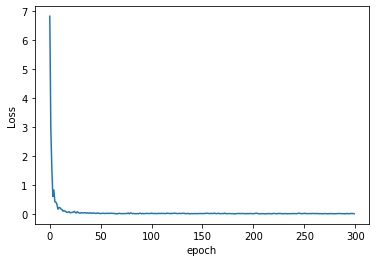

-Prediction: tensor([0.3902, 0.3952, 0.2106])
-Target: tensor([0.3333, 0.6667, 0.0000], dtype=torch.float64)


In [724]:
model = train_model(train_data)

# making a sample prediction
with torch.no_grad():
    preds = model(input_states.float())
    
a = np.random.randint(10)
print(f' - Prediction: {preds[a]}\n - Target: {output_labels[a]}')
# No need to worry about absolute values: only interested in the rankings

In [201]:
###################################################
### Preference-Based Policy Iteration Algorithm ###

### Functionality:
### - INPUTS  : sample states (s'), initial (random) policy (\pi0), max. num. of policy iterations (p)
### - PROCESS : generate roll-out (fixed time horizon) and calculate accumulate reward
### - OUTPUT  : compare return from each rollout: store preference info in training dataset as (s,a_k > a_j)


# initialize environment
env = gym.make('CartPole-v0')

# initial random policy
policy_init = random_action
policy = policy_init

# sample states
sample_states = generate_init_states_S(seed = 16) # randomly generated states initial

# maximum number of policy iterations
max_iterr = 1 # increase this after writing the LabelRanker

# action space to consider
act_space = partition_action_space(env,3)

# generate action-pairs (per each)
act_pairs = list(itertools.combinations(act_space,2))

# place-holder for training data
train_data = []

iterr = 0

pbar = tqdm.tqdm(total=max_iterr)

while iterr < max_iterr:
    
    # place-holder for training data
    #train_data = [] # uncomment this after adding LabelRanker

    
    for state in sample_states:
        
        for action_pair in act_pairs:
            preference_out = evaluate_preference(state, action_pair[0], action_pair[1], policy)
            
            if preference_out is not None:
                train_data.append(preference_out)
            else:
                pass
            
    pbar.update(1)
    iterr += 1
    
    
pbar.close()
### Train LaberRanker using train-data
### Create new policy using LabeRanker
### Re-run loop with new policy

        
        
    




100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


### `LABEL-RANKER` Model training Experiment

Training model...
epoch:   0 loss: 2.39541817
epoch:  25 loss: 0.02365649
epoch:  50 loss: 0.09631121
epoch:  75 loss: 0.05344461
epoch: 100 loss: 0.14437440
epoch: 125 loss: 0.03273392
epoch: 150 loss: 0.04118802
epoch: 175 loss: 0.02512840
epoch: 200 loss: 0.02410264
epoch: 225 loss: 0.04048956
epoch: 250 loss: 0.02288586
epoch: 275 loss: 0.07751641

Training loss:  0.03327476 


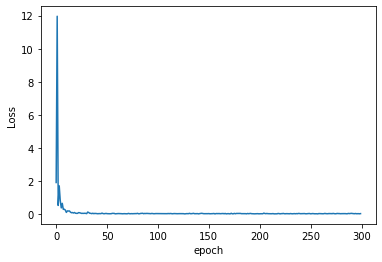

In [703]:
model = train_model(train_data)

In [826]:
### LABEL RANKER (POLICY) ###

# This takes the trained model as an input
# When a new state is given, the model makes a prediction for each action
# This function then rank the actions based on the prediction
# I select the Highest ranked (most prefered action) 90% time and second most preferred action 10% time

def label_ranking_policy(obs,model):
    
    state_obs = obs[[2,3]] # only select angel and angular velo. of pendulum from state vector
    state_obs = state_obs.reshape(-1,state_obs.shape[0]) # reshape to be a 2D array
    state_obs = torch.from_numpy(state_obs) # convert to a tensor

    # make the prediction for actions
    with torch.no_grad():
        preds = model(state_obs.float()) 

    # rank the indexes of actions (from highest ranked/preferred action to lowest)
    ranked_action_idx = (-rd(preds.detach().numpy())).argsort()[:preds.shape[1]]

    # return the action value
    remain_probs = .1/len(ranked_action_idx[2:])
    n_remain_actions = ranked_action_idx.shape[0]-2

    # - select first two (highest preferred actions) 80% and 10% of the time
    # - select one of the remaining actions 10% time
    action = np.random.choice(ranked_action_idx,1 , p=[0.8, 0.1] + list(np.repeat(remain_probs,n_remain_actions)))[0]

    return action

In [825]:
label_ranking_policy(observation,model)

0

---

## APPENDIX

#### TRAINING DATASET PREP + MODEL + TRAINING [BREAKDOWN]

In [690]:
# create a training dataframe
train_df = pd.DataFrame(train_data)
train_df.head(3)

,state,a_j,a_k,preference_label
0,"[-0.04042570338131652, 0.2768141014688637]",-0.122154,0.377846,0
1,"[-0.04042570338131652, 0.2768141014688637]",-0.122154,0.877846,0
2,"[-0.04042570338131652, 0.2768141014688637]",0.377846,0.877846,0


In [359]:
# create a key for state
train_df.loc[:, 'state_key'] = train_df.state.apply(lambda x: x[0].astype(str)+"_"+x[1].astype(str))

In [360]:
# drop all states which does not have any preferred action
temp_df1 = train_df.groupby('state_key').preference_label.sum().reset_index()
temp_df1 = temp_df1.loc[temp_df1.preference_label>0] # pick the states that have at least one prefered action
train_df = train_df.merge(right = temp_df1.loc[:,'state_key']
                          , right_on = 'state_key'
                          , left_on = 'state_key'
                          , how = 'right')

In [361]:
# create a single column with the set of actions executed per state
temp_df1 = train_df.groupby('state_key')['a_j'].unique().reset_index()
temp_df2 = train_df.groupby('state_key')['a_k'].unique().reset_index()
temp_df3 = temp_df1.merge(right=temp_df2
                          , right_on = 'state_key'
                          , left_on = 'state_key'
                          , how = 'inner')
temp_df3.loc[:,'unique_acts'] = temp_df3.apply(lambda row: set(list(row['a_j']) + list(row['a_k'])) ,axis=1)

In [362]:
temp_df3.head(2)

,state_key,a_j,a_k,unique_acts
0,-0.007119426465262891_0.010133984961571807,"[-0.12215383778081441, 0.3778461622191856]","[0.3778461622191856, 0.8778461622191855]","{-0.12215383778081441, 0.8778461622191855, 0.3..."
1,-0.035456221985432065_-0.331823583123806,"[-0.12215383778081441, 0.3778461622191856]","[0.3778461622191856, 0.8778461622191855]","{-0.12215383778081441, 0.8778461622191855, 0.3..."


In [363]:
# add the unique-action column to train dataset
train_df = train_df.merge(right = temp_df3.loc[:,['state_key', 'unique_acts']]
              , right_on =  'state_key'
              , left_on = 'state_key'
              , how = 'left')

In [365]:
# create a 'prefered-action' value for each state
train_df.loc[:,'prefered_action'] = train_df.apply(lambda row: row['a_j'] if row['preference_label'] == 1 else row['a_k']  ,axis=1)

In [366]:
train_df.head(2)

,state,a_j,a_k,preference_label,state_key,unique_acts,prefered_action
0,"[-0.035456221985432065, -0.331823583123806]",-0.122154,0.377846,0,-0.035456221985432065_-0.331823583123806,"{-0.12215383778081441, 0.8778461622191855, 0.3...",0.377846
1,"[-0.035456221985432065, -0.331823583123806]",-0.122154,0.877846,1,-0.035456221985432065_-0.331823583123806,"{-0.12215383778081441, 0.8778461622191855, 0.3...",-0.122154


In [367]:
# count the number of times each action is prefered at a state
action_preference_counts = train_df.groupby('state_key').prefered_action.value_counts().unstack()
action_preference_counts.replace(np.nan,0,inplace=True)
action_preference_counts.head()

prefered_action,-0.122154,0.377846,0.877846
state_key,,,
-0.007119426465262891_0.010133984961571807,1.0,1.0,1.0
-0.035456221985432065_-0.331823583123806,1.0,2.0,0.0
-0.042092693647908186_-0.635473455421564,1.0,2.0,0.0
-0.054802162756339465_-0.9411095238977125,2.0,1.0,0.0
-0.07362435323429371_-0.6661375648946086,2.0,1.0,0.0


In [368]:
### convert the action-preference-counts to a vector (to be used as training labels)
action_preference_counts.loc[:, 'preference_label_vector'] = action_preference_counts.iloc[:,0:].values.tolist()

In [369]:
action_preference_counts.head()

prefered_action,-0.12215383778081441,0.3778461622191856,0.8778461622191855,preference_label_vector
state_key,,,,
-0.007119426465262891_0.010133984961571807,1.0,1.0,1.0,"[1.0, 1.0, 1.0]"
-0.035456221985432065_-0.331823583123806,1.0,2.0,0.0,"[1.0, 2.0, 0.0]"
-0.042092693647908186_-0.635473455421564,1.0,2.0,0.0,"[1.0, 2.0, 0.0]"
-0.054802162756339465_-0.9411095238977125,2.0,1.0,0.0,"[2.0, 1.0, 0.0]"
-0.07362435323429371_-0.6661375648946086,2.0,1.0,0.0,"[2.0, 1.0, 0.0]"


In [370]:
# add preference label vector to training dataset
train_df = train_df.merge(right = action_preference_counts.loc[:,['preference_label_vector']]
                          , right_index= True
                          , left_on = 'state_key'
                          , how = 'left')

In [371]:
train_df.head(2)

,state,a_j,a_k,preference_label,state_key,unique_acts,prefered_action,preference_label_vector
0,"[-0.035456221985432065, -0.331823583123806]",-0.122154,0.377846,0,-0.035456221985432065_-0.331823583123806,"{-0.12215383778081441, 0.8778461622191855, 0.3...",0.377846,"[1.0, 2.0, 0.0]"
1,"[-0.035456221985432065, -0.331823583123806]",-0.122154,0.877846,1,-0.035456221985432065_-0.331823583123806,"{-0.12215383778081441, 0.8778461622191855, 0.3...",-0.122154,"[1.0, 2.0, 0.0]"


In [380]:
# create the reduced training dataset (drop unnecessary columns + duplicate rows: which have data for same state)
train_df_reduced = train_df.loc[:,['state', 'state_key', 'unique_acts', 'preference_label_vector']]

train_df_reduced.drop_duplicates(subset=['state_key'],inplace=True)
train_df_reduced.head(3)

,state,state_key,unique_acts,preference_label_vector
0,"[-0.035456221985432065, -0.331823583123806]",-0.035456221985432065_-0.331823583123806,"{-0.12215383778081441, 0.8778461622191855, 0.3...","[1.0, 2.0, 0.0]"
3,"[-0.042092693647908186, -0.635473455421564]",-0.042092693647908186_-0.635473455421564,"{-0.12215383778081441, 0.8778461622191855, 0.3...","[1.0, 2.0, 0.0]"
6,"[-0.054802162756339465, -0.9411095238977125]",-0.054802162756339465_-0.9411095238977125,"{-0.12215383778081441, 0.8778461622191855, 0.3...","[2.0, 1.0, 0.0]"


In [ ]:
# above dataset has - state + list of actions + # preferences made for each action (at state) --> each row

In [560]:
output_labels_temp = np.array(train_df_reduced.preference_label_vector.tolist())
row_sums = output_labels_temp.sum(axis=1)
output_labels_normalized = output_labels_temp / row_sums[:, np.newaxis]

In [561]:
# create training dataset
input_states  = torch.from_numpy(np.array(train_df_reduced.state.apply(lambda x: x.astype(float)).tolist()))
output_labels = torch.from_numpy(output_labels_normalized)

In [562]:
# Import tensor dataset & data loader
from torch.utils.data import TensorDataset, DataLoader

In [563]:
train_ds = TensorDataset(input_states , output_labels )

In [564]:
# Define data loader
batch_size = 3
train_dl = DataLoader(train_ds, batch_size, shuffle=True, drop_last=True)
next(iter(train_dl))

[tensor([[ 0.0616,  0.3560],
         [ 0.0463,  1.1982],
         [-0.0355, -0.3318]], dtype=torch.float64),
 tensor([[0.3333, 0.0000, 0.6667],
         [0.3333, 0.0000, 0.6667],
         [0.3333, 0.6667, 0.0000]], dtype=torch.float64)]

In [440]:
class Model(nn.Module):

    def __init__(self, input_state_len, output_label_len, layers, p=0.4):
        
        super().__init__()
        self.batch_norm_num = nn.BatchNorm1d(input_state_len)

        all_layers = []
        input_size = input_state_len

        # create layers
        for layer_dim in layers:
            all_layers.append(nn.Linear(input_size, layer_dim))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(layer_dim))
            all_layers.append(nn.Dropout(p))
            input_size = layer_dim

        all_layers.append(nn.Linear(layers[-1], output_label_len))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, state_vec):
        x = self.batch_norm_num(state_vec)
        x = self.layers(x)
        return x

In [670]:
# Define model
model = Model(input_states.shape[1], output_labels.shape[1], [100,500,50], p=0.4)

In [680]:
opt = torch.optim.SGD(model.parameters(), lr = 1e-1)
loss_fn = F.mse_loss

In [681]:
# to store losses
aggregated_losses = []

# Define a utility function to train the model
def fit(num_epochs, model, loss_fn, opt):
    
    for epoch in range(num_epochs):
        for xb,yb in train_dl:
            
            # Generate predictions
            pred = model(xb.float())
            loss = loss_fn(pred, yb.float())            
            
            # Perform gradient descent
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        aggregated_losses.append(loss_fn(model(input_states.float()), output_labels.float()).detach().numpy())
        
        if epoch%25 == 0:
                print(f'epoch: {epoch:3} loss: {loss.item():10.8f}')
            
    print('Training loss: ', loss_fn(model(input_states.float()), output_labels.float()))

In [682]:
epochs= 300
fit(epochs, model, loss_fn, opt)

epoch:   0 loss: 1.26457167
epoch:  25 loss: 0.03228344
epoch:  50 loss: 0.11356914
epoch:  75 loss: 0.03096418
epoch: 100 loss: 0.03917579
epoch: 125 loss: 0.09606967
epoch: 150 loss: 0.03857052
epoch: 175 loss: 0.10947236
epoch: 200 loss: 0.03288856
epoch: 225 loss: 0.12105025
epoch: 250 loss: 0.08336683
epoch: 275 loss: 0.06543268
Training loss:  tensor(0.0267, grad_fn=<MseLossBackward>)


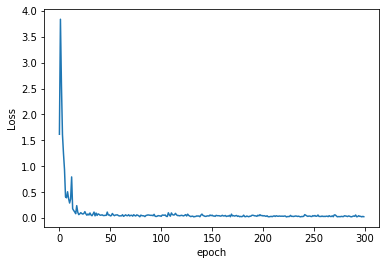

In [697]:
plt.plot(range(epochs), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()

---

#### Label Ranking Policy

In [821]:
env = gym.make('CartPole-v0')
observation = env.reset()

state_obs = observation[[2,3]] # only select angel and angular velo. of pendulum from state vector
state_obs = state_obs.reshape(-1,state_obs.shape[0]) # reshape to be a 2D array
state_obs = torch.from_numpy(state_obs) # convert to a tensor

# make the prediction for actions
with torch.no_grad():
    preds = model(state_obs.float()) 
    
# rank the indexes of actions (from highest ranked/preferred action to lowest)
ranked_action_idx = (-rd(preds.detach().numpy())).argsort()[:preds.shape[1]]

# return the action value
remain_probs = .1/len(ranked_action_idx[2:])
n_remain_actions = ranked_action_idx.shape[0]-2

# - select first two (highest preferred actions) 80% and 10% of the time
# - select one of the remaining actions 10% time
action = np.random.choice(ranked_action_idx,1 , p=[0.8, 0.1] + list(np.repeat(remain_probs,n_remain_actions)))[0]

action

0

---

### Visualize episode

##### METHOD 1:

In [698]:
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()
for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done: break
env.close()

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

##### METHOD 2:

episode 19 finished after 8 timesteps. Total reward: 8.0


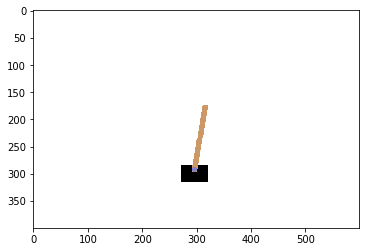

In [5]:
nb_episodes = 20
nb_timesteps = 100
img = plt.imshow(env.render(mode='rgb_array')) # only call this once

for episode in range(nb_episodes):  # iterate over the episodes
    state = env.reset()             # initialise the environment
    rewards = []
    
    for t in range(nb_timesteps):    # iterate over time steps
        #env.render()                 # display the environment
        img.set_data(env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, info = env.step(0)  # implement the action chosen by the policy
        rewards.append(reward)      # add 1 to the rewards list
        
        if done: # the episode ends either if the pole is > 15 deg from vertical or the cart move by > 2.4 unit from the centre
            cumulative_reward = sum(rewards)
            print("episode {} finished after {} timesteps. Total reward: {}".format(episode, t+1, cumulative_reward))  
            break
    
env.close()

##### OTHER USEFUL-INFO: